In [54]:
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.ndimage import convolve
from sklearn.metrics import pairwise_distances
import tifffile
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
raw_pd1 = None
with h5py.File("data/cube.h5", "r") as cube:
    raw_pd1 = np.array(cube["CD8A"])

In [10]:
print(raw_pd1.shape, raw_pd1.max(), raw_pd1.min())

(10, 1024, 1024) 31545 0


In [11]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

def cube_2_coords(cube, threshold=0):
    coords = []
    np_coords = np.where(np.logical_and(cube>=0.01, cube<=0.02))
    for z,y,x in tqdm(zip(*np_coords), total=len(np_coords[0])):
        coords.append([z, y, x, cube[z, y, x]])
    return np.array(coords, dtype=np.int16)

def coords_2_cube(coords, labels, dim):
    cube = np.zeros((dim))
    for coord, label in zip(coords, labels):
        cube[int(coord[0]), int(coord[1]), int(coord[2])] = label
    return cube

def prepare_cube(cube, threshold=0):
    coords = cube_2_coords(cube, threshold)
    return coords

def generate_pairwise_distances(X, metric="euclidean"):
    return pairwise_distances(X, metric=metric)


def dbscan_markers(X, eps, min_samples, n_jobs=1, gpu=False, metric="euclidean"):
    from sklearnex import patch_sklearn, config_context
    patch_sklearn()
    if gpu:
        with config_context(target_offload="gpu:0"):
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            db.fit(X)
    else:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs, metric=metric)
        db.fit(X)
    labels = db.labels_
    return labels

def show_clusters(coords, labels):
    with h5py.File("data/cube.h5", "r") as cube:
        dna = cube["DNA1"]
        #dna = np.expand_dims(dna, 0)
        clusters = coords_2_cube(coords, labels, dna.shape)
        masked = np.ma.masked_where(clusters == -1, clusters)
        for i in range(0, len(dna), 1):
            plt.figure(figsize=(8, 8))
            
            plt.imshow(dna[i], 'gray', interpolation='none')
            plt.imshow(masked[i], 'jet', interpolation='none', alpha=0.5)
            plt.tight_layout()
            plt.figure(i+1)

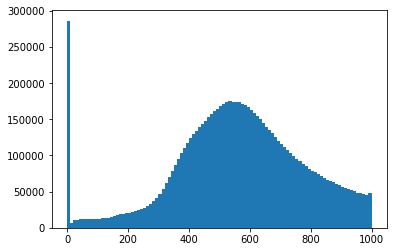

In [15]:
pd1 = raw_pd1
#pd1 = np.expand_dims(pd1, 0, )
plt.hist(pd1.reshape(-1), bins=100, range=[0,1000])
plt.show()

In [23]:
coords = cube_2_coords(pd1, 0)

100%|██████████| 4408498/4408498 [00:03<00:00, 1220093.52it/s]


In [24]:
sample_size = 600000
#sampled_idx = np.random.choice(np.arange(len(coords)), sample_size, p=(coords[:,-1]/coords[:,-1].sum()))
sampled_idx = np.random.choice(np.arange(len(coords)), sample_size)

In [25]:
sampled_coords = coords[sampled_idx,:-1]
print(sampled_coords.shape)

(600000, 3)


In [26]:
sampled_coords

array([[   8,  734,  201],
       [   0,  560,  174],
       [   2,  763, 1001],
       ...,
       [   2,  218,  233],
       [   0,  885,  228],
       [   4,  534,   42]], dtype=int16)

In [27]:
labels = dbscan_markers(sampled_coords, 10, 20, n_jobs=6)
#labels = KMeans(25).fit(sampled_coords).labels_

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [28]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32)

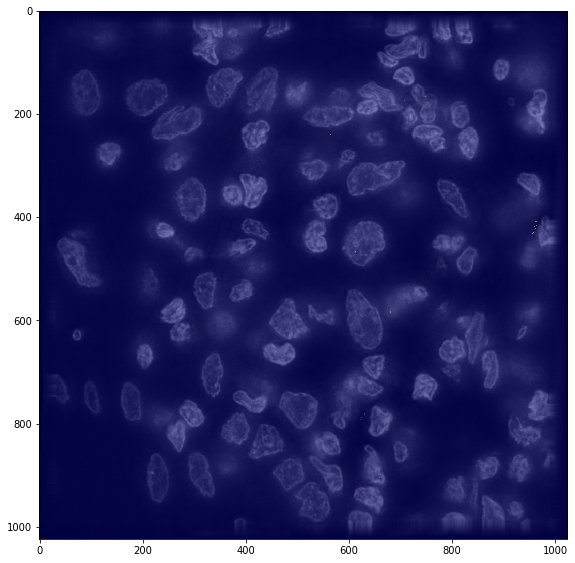

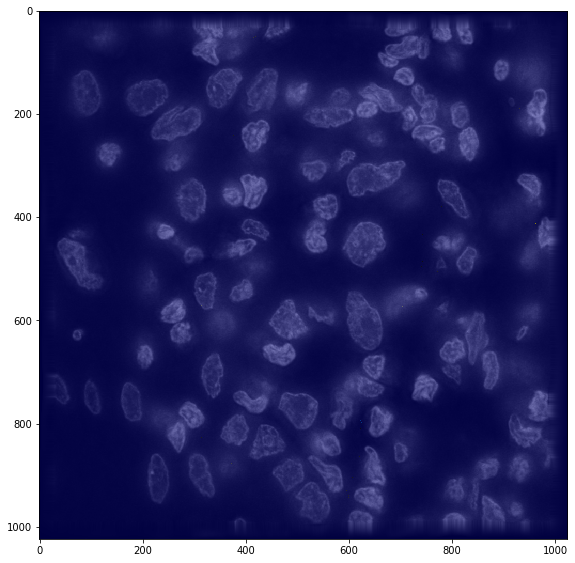

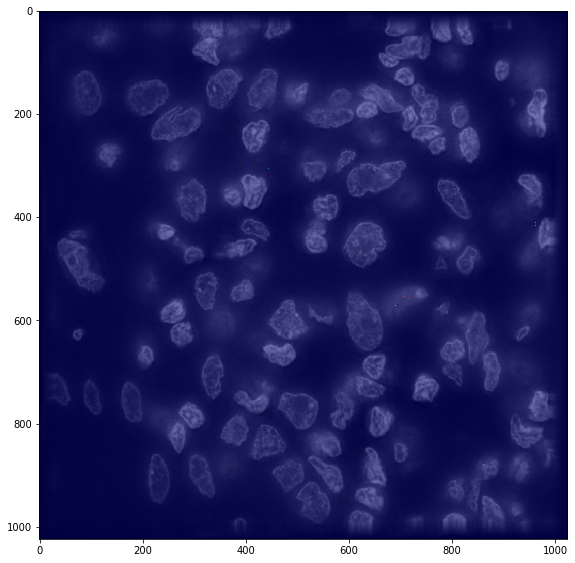

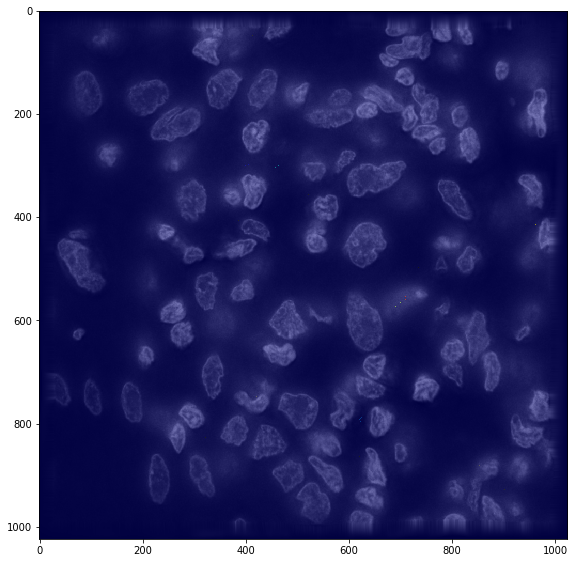

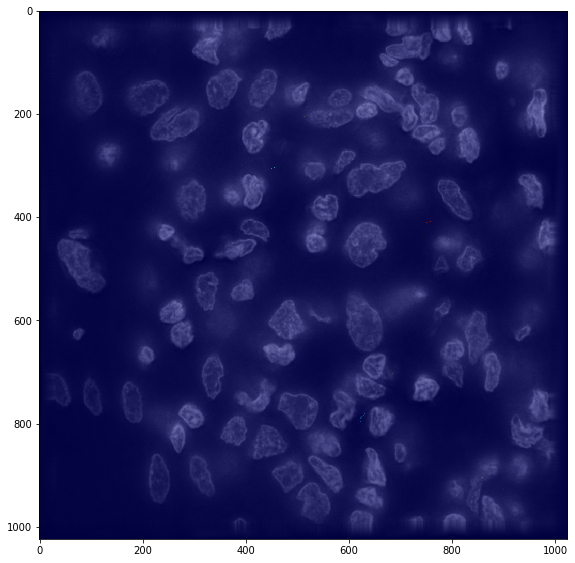

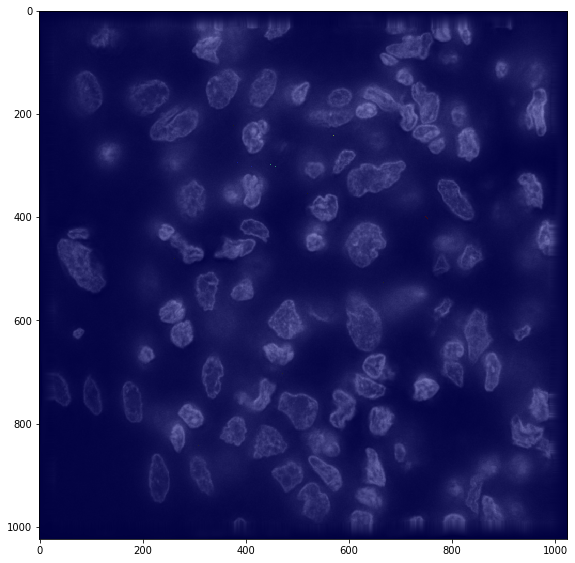

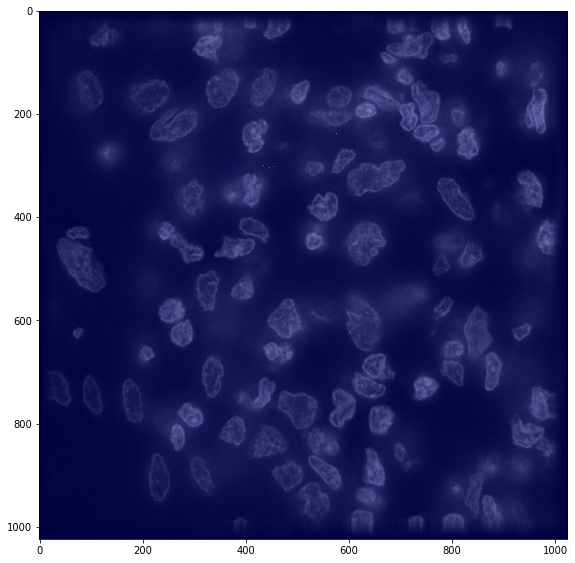

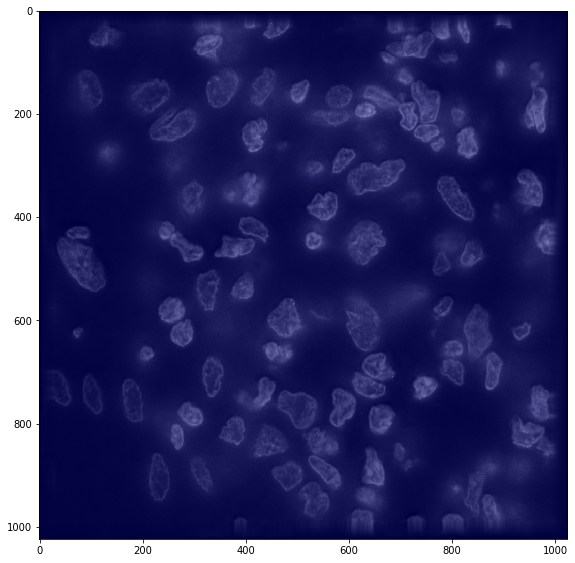

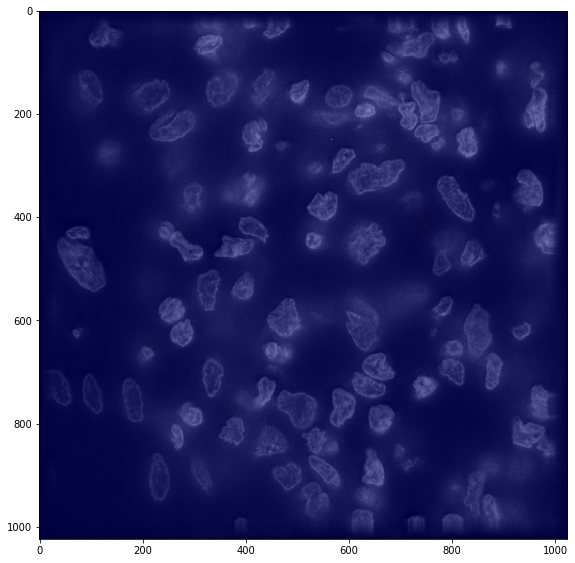

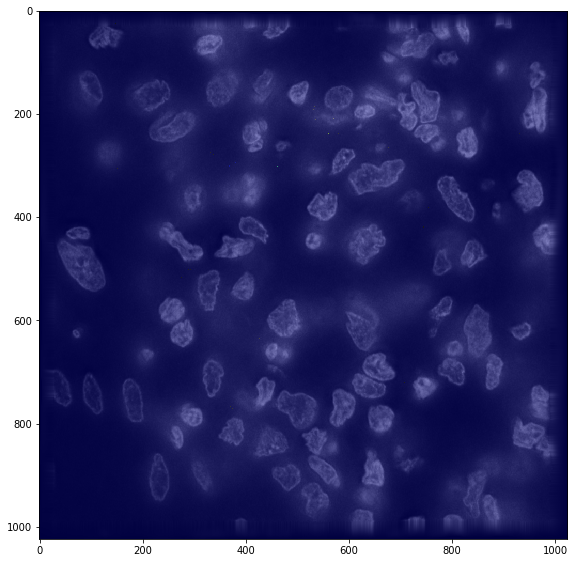

In [29]:
show_clusters(sampled_coords, labels)

In [55]:
marker_names = ["DNA1","PD1","TLR3","SOX10","DNA2","CD163",
"CD3D","PDL1","DNA3","CD4","ICOS","HLADPB1","DNA4","CD8A",
"CD68","GZMB","DNA5","CD40L","LAG3","HLAA","DNA6","SQSTM",
"VIN","TIM3","DNA7","LAMP1/CD107A","PDL1_2","PD1_2", "masks"]

In [56]:
file = "data/3_01_R3D_D3D_3D_MERGED.tiff"
img = tifffile.imread(file)

with h5py.File("data/cube.h5", "w") as cube:
    for c in tqdm(range(img.shape[1])):
        cube[marker_names[c]] = img[:,c,:,:]

100%|██████████| 29/29 [00:00<00:00, 40.66it/s]


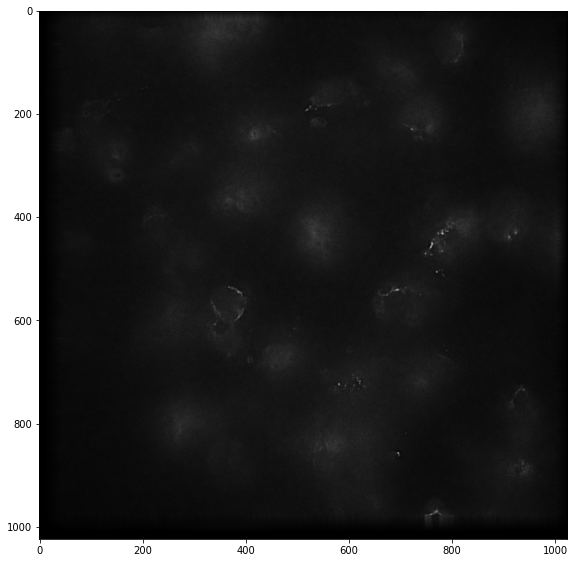

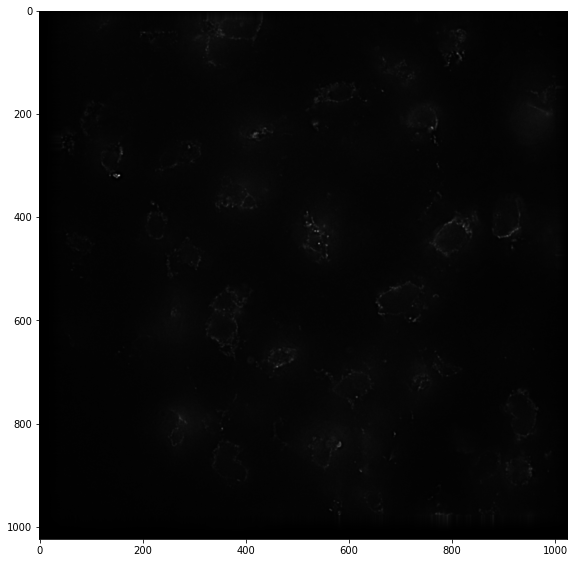

<Figure size 432x288 with 0 Axes>

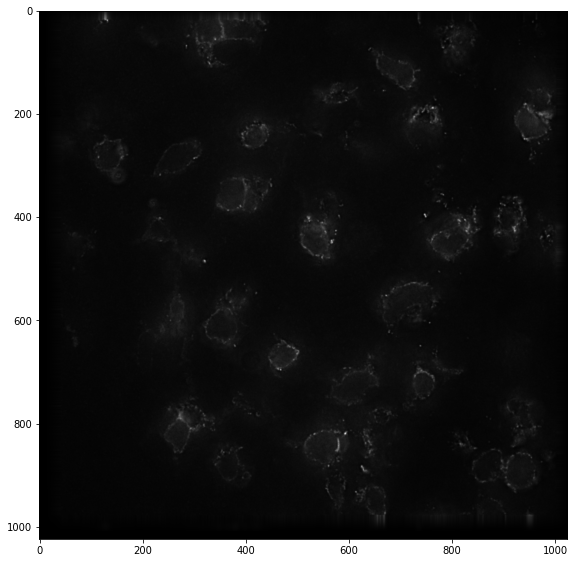

<Figure size 432x288 with 0 Axes>

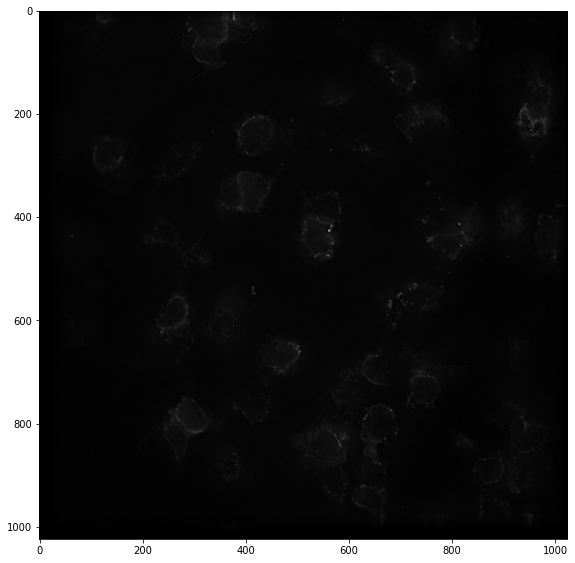

<Figure size 432x288 with 0 Axes>

In [57]:
with h5py.File("data/cube.h5", "r") as cube:
    img = cube["CD8A"]
    for i in range(0, len(img), 10):
        plt.figure(figsize=(8, 8))
        plt.imshow(img[i], 'gray')
        plt.tight_layout()
        plt.figure(i+1)

In [144]:
from skimage.measure import label, regionprops

def region_growing(centroids, markers):
    regions = regionprops(centroids)
    markers = np.array(markers)
    #marker_coords = np.nonzero(markers)
    marker_coords = np.where(np.logical_and(markers>=700, markers<=1000))
    #skip_step = 300
    #step = 0
    clusters = np.zeros((markers.shape))
    
    for z, y, x in tqdm(zip(*marker_coords), total=len(marker_coords[0])):
        clusters[z][y][x] = 1
        return
        if np.random.randint(0,10) != 0:
            continue
        nearest_dist = np.linalg.norm([z,y,z] - np.array(regions[0].centroid))
        nearest_label = regions[0].label
        for r in regions:
            ndist = np.linalg.norm([z,y,z] - np.array(r.centroid))
            if ndist < nearest_dist:
                nearest_dist = ndist
                nearest_label = r.label
        clusters[z][y][x] = nearest_label
        step = 0
    return clusters
        

In [145]:
with h5py.File("data/cube.h5", "r") as cube:
    
    masks = np.array(cube['masks'])[28:30,:,:]
    cd8a = np.array(cube['CD8A'])[28:30,:,:]
    print(masks.shape, cd8a.shape)

(2, 1024, 1024) (2, 1024, 1024)


In [146]:
clusters = region_growing(masks, cd8a)

100%|██████████| 452353/452353 [00:50<00:00, 9027.49it/s] 


In [147]:
len(np.unique(clusters))

11

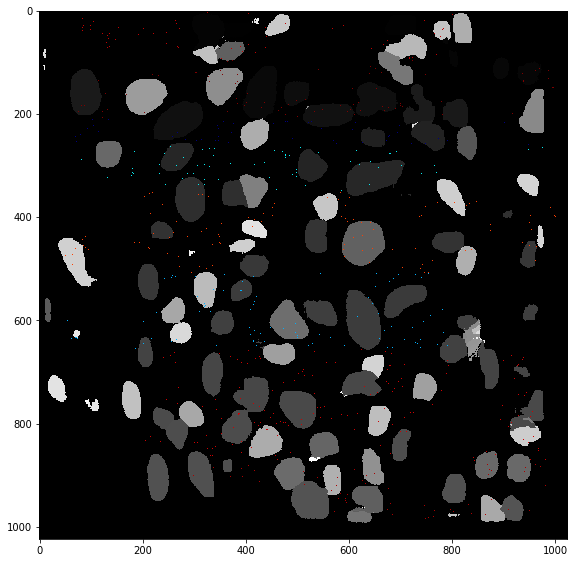

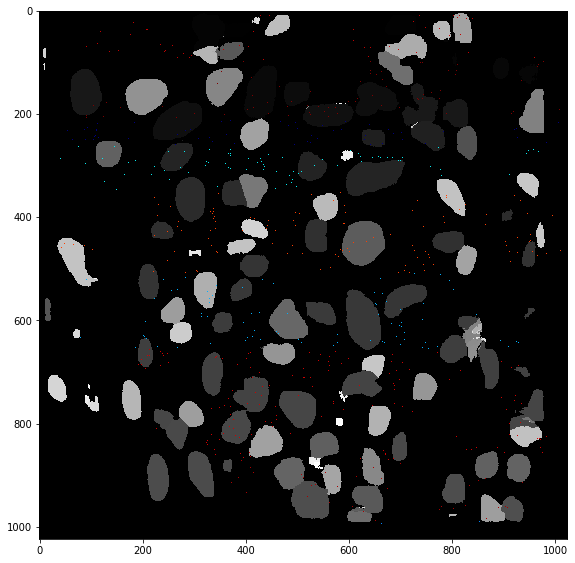

In [148]:
with h5py.File("data/cube.h5", "r") as cube:
    dna = cube["masks"][28:30,:,:]
    #masks = cube["masks"][25:30, 300:600, 300:600]
    #clusters += masks
    masked = np.ma.masked_where(clusters ==0, clusters)
    #masked2 = np.ma.masked_where(masks ==0, masks)
    for i in range(0, len(dna), 1):
        plt.figure(figsize=(8, 8))
        
        plt.imshow(dna[i], 'gray', interpolation='none')
        plt.imshow(masked[i], 'jet', interpolation='none')
        #plt.imshow(masked2[i], 'jet', interpolation='none')
        plt.tight_layout()
        plt.figure(i+1)